In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
def flip_image(image): 
    flipped_image = image[::-1]
    return flipped_image

data = pd.read_csv("data/CATSnDOGS.csv")
labels = pd.read_csv("data/labels.csv")

for i in range(len(data)):
    if i%2==0:
        data.iloc[i] = flip_image(data.iloc[i])
    

Some pre-processing, ex find number of PC for kNN ans such

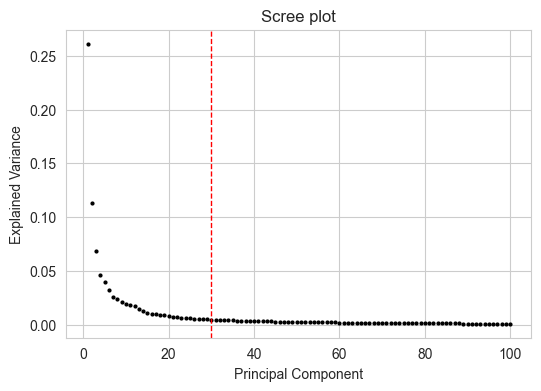

In [3]:
# This should maybe only be done for training data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

trainX_pp = StandardScaler().fit_transform(train_data)
train_data_pca = PCA().fit(trainX_pp)
principal_components_pca = train_data_pca.transform(trainX_pp)

# Plot the importance of the principal components
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

num_components_to_plot = min(100, len(train_data_pca.explained_variance_ratio_))
ax.plot(np.arange(1, num_components_to_plot + 1), train_data_pca.explained_variance_ratio_[:num_components_to_plot], 'ok', markersize=2)
ax.axvline(30, linestyle="dashed", color="red", linewidth=1)
plt.title('Scree plot')
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")
plt.show()

In [16]:
#Top 30 PC looks reasonable 
num_principal_components = 30
num_tests = 50
pca = PCA(n_components=num_principal_components)
scaler = StandardScaler()

#Initialize classifiers
knn_classifier_flexible = KNeighborsClassifier(n_neighbors=3)
knn_classifier_rigid = KNeighborsClassifier(n_neighbors=50)
random_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1)

log_reg = LogisticRegression()
svm_classifier = SVC(kernel='linear')  # Linear kernel for linear SVM

knn_flexible_scores = []
knn_flexible_correct_dogs = []
knn_flexible_correct_cats = []
knn_flexible_mislabeled_idx = []

knn_rigid_scores = []
knn_rigid_mislabeled_idx = []
knn_rigid_correct_dogs = []
knn_rigid_correct_cats = []

random_forest_scores = []
random_forest_mislabeled_idx = []
random_forest_correct_dogs = []
random_forest_correct_cats = []

log_reg_scores = []
log_reg_mislabeled_idx = []
log_reg_correct_dogs = []
log_reg_correct_cats = []

svm_scores = []
svm_mislabeled_idx = []
svm_correct_dogs = []
svm_correct_cats = []


def get_mislabeled_idx(classifier, test_data, test_labels):
    y_pred = classifier.predict(test_data)
    misclassified_idx = np.where(y_pred != test_labels.to_numpy().squeeze())[0]
    misclassified_idx = test_data.iloc[misclassified_idx].index
    return misclassified_idx

for i in range(num_tests):
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.4)
    
    # Fit the scaler on the training data and transform the training data
    train_data_scaled = scaler.fit_transform(train_data)
    train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_data.columns, index=train_data.index)
    
    # Transform the test data using the already fitted scaler
    test_data_scaled = scaler.transform(test_data)
    test_data_scaled = pd.DataFrame(test_data_scaled, columns=test_data.columns, index=test_data.index)
    
    num_dogs = np.sum(test_labels.values.ravel() == 1)
    num_cats = np.sum(test_labels.values.ravel() == 0)
    
    # Evaluate flexible KNN classifier
    knn_classifier_flexible.fit(train_data_scaled, train_labels.values.ravel())
    predictions = knn_classifier_flexible.predict(test_data_scaled)
    scores_knn_flexible = accuracy_score(test_labels.values.ravel(), predictions)
    knn_flexible_scores.append(scores_knn_flexible)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    knn_flexible_correct_cats.append(correct_cats)
    knn_flexible_correct_dogs.append(correct_dogs)
    
    # Evaluate rigid KNN classifier
    knn_classifier_rigid.fit(train_data_scaled, train_labels.values.ravel())
    knn_classifier_rigid.predict(test_data_scaled)
    predictions = knn_classifier_rigid.predict(test_data_scaled)
    scores_knn_rigid = accuracy_score(test_labels.values.ravel(), predictions)
    knn_rigid_scores.append(scores_knn_rigid)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    knn_rigid_correct_cats.append(correct_cats)
    knn_rigid_correct_dogs.append(correct_dogs)
    
    # Evaluate Random Forest 
    random_forest.fit(train_data, train_labels.values.ravel())
    random_forest.predict(test_data)
    predictions = random_forest.predict(test_data)
    rf_test_accuracy = accuracy_score(test_labels.values.ravel(), predictions)
    random_forest_scores.append(rf_test_accuracy)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    random_forest_correct_cats.append(correct_cats)
    random_forest_correct_dogs.append(correct_dogs)
    

    
    # Evaluate Logistic Regression
    log_reg.fit(train_data, train_labels.values.ravel())
    predictions = log_reg.predict(test_data)
    log_reg_test_accuracy = accuracy_score(test_labels.values.ravel(), predictions)
    log_reg_scores.append(log_reg_test_accuracy)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    log_reg_correct_cats.append(correct_cats)
    log_reg_correct_dogs.append(correct_dogs)
    
    
    # Fit and evaluate the SVM classifier
    svm_classifier.fit(train_data, train_labels.values.ravel())
    predictions = svm_classifier.predict(test_data)
    scores_svm = accuracy_score(test_labels.values.ravel(), predictions)
    svm_scores.append(scores_svm)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    svm_correct_cats.append(correct_cats)
    svm_correct_dogs.append(correct_dogs)
    
    
    
    knn_flexible_mislabeled_idx.append(get_mislabeled_idx(knn_classifier_flexible, test_data_scaled, test_labels))
    knn_rigid_mislabeled_idx.append(get_mislabeled_idx(knn_classifier_rigid, test_data_scaled, test_labels))
    random_forest_mislabeled_idx.append(get_mislabeled_idx(random_forest, test_data, test_labels))
    log_reg_mislabeled_idx.append(get_mislabeled_idx(log_reg, test_data, test_labels))
    svm_mislabeled_idx.append(get_mislabeled_idx(svm_classifier, test_data, test_labels))
    
    

    
print("Test scores for the test set size 40% ")
print('KNN flexible scores:', np.mean(knn_flexible_scores))
print('KNN rigid scores:', np.mean(knn_rigid_scores))
print('Random forest scores:', np.mean(random_forest_scores))
print('Logistic regression scores:', np.mean(log_reg_scores))
print('SVM scores:', np.mean(svm_scores))

Test scores for the test set size 40% 
KNN flexible scores: 0.6345000000000001
KNN rigid scores: 0.51825
Random forest scores: 0.64
Logistic regression scores: 0.6510000000000001
SVM scores: 0.634


In [17]:

from scipy.stats import f_oneway



f_stat, p_val = f_oneway(knn_flexible_scores, knn_rigid_scores, random_forest_scores, log_reg_scores, svm_scores)
print("ANOVA p-value:", p_val)


ANOVA p-value: 3.7009053623780834e-34


Text(0, 0.5, 'Accuracy')

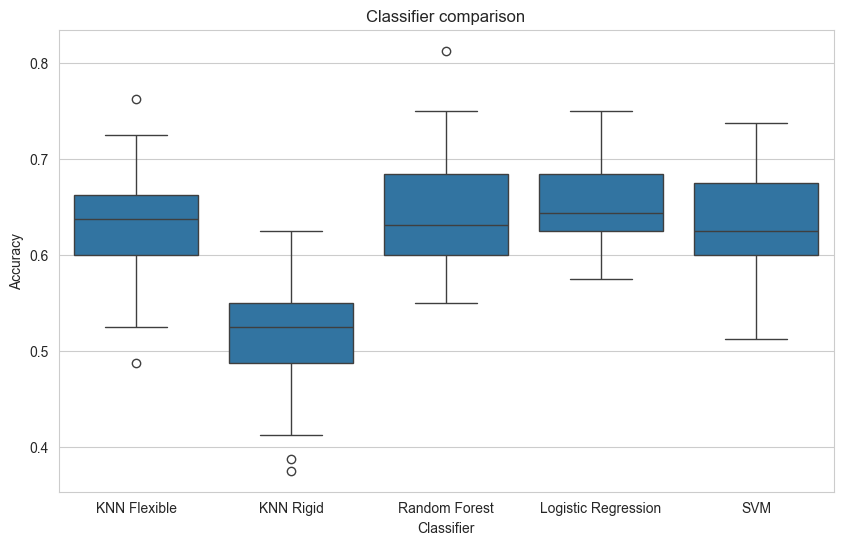

In [18]:
import seaborn as sns

# create boxplots

# Create a dictionary to store the results

results = {
    'KNN Flexible': knn_flexible_scores,
    'KNN Rigid': knn_rigid_scores,
    'Random Forest': random_forest_scores,
    'Logistic Regression': log_reg_scores,
    'SVM': svm_scores
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(results)

# Melt the DataFrame to the long format
df_melt = df.melt(var_name='Classifier', value_name='Accuracy')

# Create a boxplot

plt.figure(figsize=(10, 6))
sns.boxplot(x='Classifier', y='Accuracy', data=df_melt)

plt.title('Classifier comparison')
plt.ylabel('Accuracy')


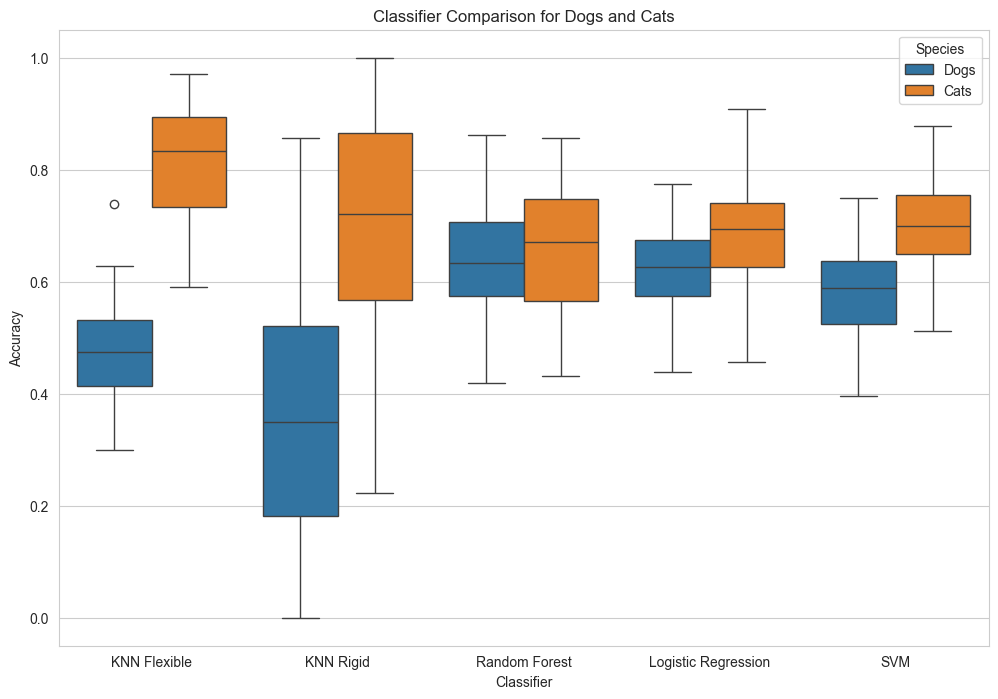

In [19]:
results = {
    'KNN Flexible Dogs': knn_flexible_correct_dogs, 
    'KNN Flexible Cats': knn_flexible_correct_cats,
    'KNN Rigid Dogs': knn_rigid_correct_dogs,
    'KNN Rigid Cats': knn_rigid_correct_cats,
    'Random Forest Dogs': random_forest_correct_dogs,
    'Random Forest Cats': random_forest_correct_cats,
    'Logistic Regression Dogs': log_reg_correct_dogs,
    'Logistic Regression Cats': log_reg_correct_cats,
    'SVM Dogs': svm_correct_dogs,
    'SVM Cats': svm_correct_cats
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(results)

# Melt the DataFrame to long format
df_melt = df.melt(var_name='Classifier_Species', value_name='Accuracy')

# Split the 'Classifier_Species' into 'Classifier' and 'Species'
df_melt[['Classifier', 'Species']] = df_melt['Classifier_Species'].str.rsplit(' ', n=1, expand=True)
df_melt = df_melt.drop(columns=['Classifier_Species'])

# Create a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Classifier', y='Accuracy', hue='Species', data=df_melt)

plt.title('Classifier Comparison for Dogs and Cats')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

In [20]:

from collections import Counter
def get_common_misclassified_idx(mislabeled_idx):
    extended_mislabeled_idx = [item for sublist in mislabeled_idx for item in sublist]
    c = Counter(extended_mislabeled_idx).most_common(10000)
    return [item[0] for item in c]

knn_flexible_common_misclassified_idx = get_common_misclassified_idx(knn_flexible_mislabeled_idx)
knn_rigid_common_misclassified_idx = get_common_misclassified_idx(knn_rigid_mislabeled_idx)
random_forest_common_misclassified_idx = get_common_misclassified_idx(random_forest_mislabeled_idx)
log_reg_common_misclassified_idx = get_common_misclassified_idx(log_reg_mislabeled_idx)
svm_common_misclassified_idx = get_common_misclassified_idx(svm_mislabeled_idx)

print("Common misclassified indices:")
print('KNN flexible:', knn_flexible_common_misclassified_idx)
print('KNN rigid:', knn_rigid_common_misclassified_idx)
print('Random forest:', random_forest_common_misclassified_idx)
print('Logistic regression:', log_reg_common_misclassified_idx)
print('SVM:', svm_common_misclassified_idx)


common = set(knn_flexible_common_misclassified_idx) & set(knn_rigid_common_misclassified_idx) & set(random_forest_common_misclassified_idx) & set(log_reg_common_misclassified_idx) & set(svm_common_misclassified_idx)
common = set(knn_flexible_common_misclassified_idx) & set(random_forest_common_misclassified_idx) & set(log_reg_common_misclassified_idx) & set(svm_common_misclassified_idx)

common

Common misclassified indices:
KNN flexible: [78, 102, 112, 185, 77, 91, 169, 5, 139, 129, 71, 98, 151, 85, 19, 41, 61, 164, 114, 9, 39, 177, 106, 88, 120, 31, 8, 89, 158, 65, 63, 25, 94, 124, 154, 143, 34, 37, 20, 103, 178, 111, 73, 125, 117, 167, 141, 14, 162, 107, 45, 175, 118, 146, 57, 100, 97, 30, 28, 40, 51, 90, 83, 96, 87, 179, 142, 67, 122, 173, 191, 190, 72, 82, 95, 144, 75, 12, 163, 189, 145, 58, 123, 147, 188, 33, 113, 176, 13, 76, 184, 192, 197, 42, 18, 160, 79, 128, 6, 66, 32, 187, 35, 149, 16, 121, 115, 26, 171, 47, 166, 69, 22, 156, 195, 38, 44, 1, 46, 105, 15, 36, 196, 4, 27, 52, 182, 2, 84, 168, 181, 132, 180, 93, 140, 59, 150, 170, 133, 0, 81, 11, 10, 62, 183, 110, 60, 134, 109, 49, 50, 99, 174, 116, 172]
KNN rigid: [169, 139, 5, 4, 195, 71, 131, 98, 124, 31, 129, 175, 14, 144, 65, 130, 41, 116, 96, 89, 19, 93, 100, 134, 123, 177, 122, 60, 115, 133, 163, 143, 6, 78, 52, 63, 113, 112, 3, 57, 66, 33, 109, 174, 0, 150, 73, 140, 102, 149, 55, 103, 79, 120, 51, 132, 15, 13,

{0,
 1,
 4,
 5,
 6,
 8,
 9,
 12,
 13,
 14,
 19,
 20,
 22,
 25,
 26,
 31,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 46,
 47,
 49,
 51,
 52,
 57,
 59,
 60,
 61,
 62,
 63,
 65,
 66,
 69,
 71,
 72,
 73,
 75,
 77,
 78,
 79,
 84,
 85,
 87,
 88,
 90,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 102,
 103,
 105,
 107,
 109,
 110,
 112,
 113,
 114,
 115,
 117,
 120,
 121,
 122,
 123,
 124,
 125,
 128,
 129,
 132,
 133,
 134,
 139,
 141,
 142,
 143,
 144,
 145,
 147,
 149,
 151,
 154,
 156,
 158,
 160,
 166,
 168,
 169,
 170,
 171,
 172,
 174,
 175,
 177,
 179,
 180,
 181,
 182,
 184,
 185,
 187,
 188,
 192,
 195,
 196,
 197}

In [21]:
def plot_wrong_images(images_idx):
    labels_map = {0: 'Cat', 1: 'Dog'}
    images = data.iloc[images_idx].values
    fig, axes = plt.subplots(1, len(images_idx), figsize=(20, 20))
    for i, (ax, img) in enumerate(zip(axes, images)):
        true_label = labels.iloc[images_idx[i]].values[0]
        ax.imshow(img.reshape(64, 64).transpose(1, 0), cmap="gray")
        ax.axis('off')
        ax.set_title(f"Predicted: {labels_map[1 - true_label]}")
        
# plot_wrong_images(knn_flexible_common_misclassified_idx)
# plot_wrong_images(knn_rigid_common_misclassified_idx)
# plot_wrong_images(random_forest_common_misclassified_idx)
# plot_wrong_images(log_reg_common_misclassified_idx)
# plot_wrong_images(svm_common_misclassified_idx)

In [22]:
# Calculate number of misclassified images that are flipped images
knn_flexible_flipped_misclassified_images = [i for i in knn_flexible_common_misclassified_idx if i % 2 == 0]
knn_rigid_flipped_misclassified_images = [i for i in knn_rigid_common_misclassified_idx if i % 2 == 0]
random_forest_flipped_misclassified_images = [i for i in random_forest_common_misclassified_idx if i % 2 == 0]
log_reg_flipped_misclassified_images = [i for i in log_reg_common_misclassified_idx if i % 2 == 0]
svm_flipped_misclassified_images = [i for i in svm_common_misclassified_idx if i % 2 == 0]

# Compute the fraction of misclassified images that are flipped
knn_flexible_flipped_fraction = len(knn_flexible_flipped_misclassified_images) / len(knn_flexible_common_misclassified_idx)
knn_rigid_flipped_fraction = len(knn_rigid_flipped_misclassified_images) / len(knn_rigid_common_misclassified_idx)
random_forest_flipped_fraction = len(random_forest_flipped_misclassified_images) / len(random_forest_common_misclassified_idx)
log_reg_flipped_fraction = len(log_reg_flipped_misclassified_images) / len(log_reg_common_misclassified_idx)
svm_flipped_fraction = len(svm_flipped_misclassified_images) / len(svm_common_misclassified_idx)

print("Fraction of misclassified images that are flipped:")
print('KNN flexible:', knn_flexible_flipped_fraction)
print('KNN rigid:', knn_rigid_flipped_fraction)
print('Random forest:', random_forest_flipped_fraction)
print('Logistic regression:', log_reg_flipped_fraction)
print('SVM:', svm_flipped_fraction)



Fraction of misclassified images that are flipped:
KNN flexible: 0.5032258064516129
KNN rigid: 0.4895833333333333
Random forest: 0.52
Logistic regression: 0.46938775510204084
SVM: 0.4720496894409938


Feature Importance: (4096,)
Feature Importance: (4096,)


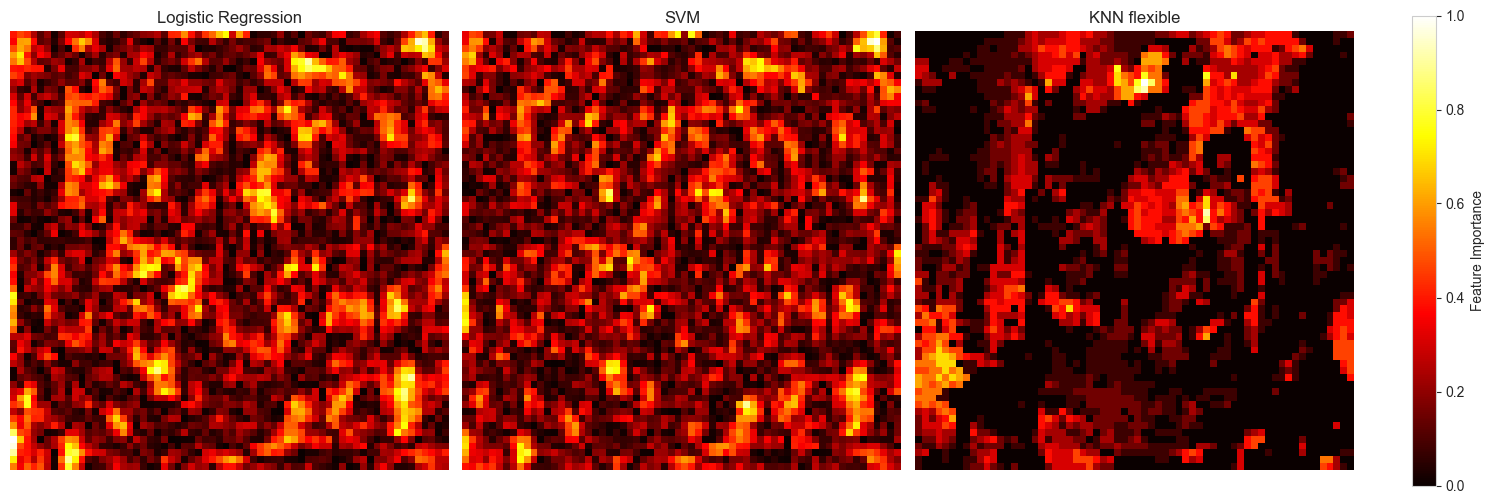

In [23]:
from sklearn.inspection import permutation_importance

# Feature importance using permutation importance
result = permutation_importance(knn_classifier_flexible, test_data_scaled, test_labels, n_repeats=10, random_state=42,
                                n_jobs=-1)
# LOgistic regression
# start a figure with a subplot with one rows and three column
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Feature importance
importance = log_reg.coef_[0]

    # Rescale importance to be between 0 and 1
importance = np.abs(importance) / np.max(np.abs(importance))
# set values below threshold to zero
#importance[importance < 0.4] = 0
image = importance.reshape(-1, 64, 64).transpose(0, 2, 1).squeeze()
print("Feature Importance:", importance.shape)
ax[0].imshow(image, cmap='hot')
ax[0].set_title('Logistic Regression')
ax[0].axis('off')
# store features with importance above threshold 0.4
# imp_features = np.where(importance > 0.4)[0]

# SVM

# Feature importance
importance = svm_classifier.coef_[0]

    # Rescale importance to be between 0 and 1
importances = np.abs(importance) / np.max(np.abs(importance))
# set values below threshold to zero
#importance[importance < 0.4] = 0
image = importances.reshape(-1, 64, 64).transpose(0, 2, 1).squeeze()
print("Feature Importance:", importances.shape)
ax[1].imshow(image, cmap='hot')
ax[1].set_title('SVM')
ax[1].axis('off')

# store features with importance above threshold 0.4
# imp_features = np.where(importance > 0.4)[0]

# KNN
importance = result.importances_mean
# Feature importance
#importance = svm_classifier.coef_[0]
# Rescale importance to be between 0 and 1
importance = np.abs(importance) / np.max(np.abs(importance))
# set values below threshold to zero
#importance[importance < 0.2] = 0
image = importance.reshape(-1, 64, 64).transpose(0, 2, 1).squeeze()
ax[2].imshow(image, cmap='hot')
ax[2].set_title('KNN flexible')
ax[2].axis('off')
fig.tight_layout()
# add colorbar
cbar = fig.colorbar(ax[2].imshow(image, cmap='hot'), ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Feature Importance')

plt.show()
